# ДЗ 2

## Соколов Игорь
### Группа 573

#### Задача 11
Нарисовать траекторию пошагового спуска к минимуму градиентного метода и имитации отжига. Сравнить их работу при поиске мимимума тестовой функции

<img src="func.png" width=linewidth align="center"/>

Будем решать задачу при $N=2$

In [29]:
%matplotlib inline
import numpy as np
import time
from matplotlib import pyplot as plt
import matplotlib as mpl
#import seaborn as sns
import scipy 

from IPython.display import Image
from IPython.core.display import HTML 
import timeit
#import numdifftools as nd
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from ipywidgets import FloatProgress
from IPython.display import display

import sys
from scipy._lib.six import callable, xrange
import go_benchmark as gb

За основу функции, реализующую алгоритм метода имитации, отжига была взята **anneal** из библиотеки **scipy** (https://goo.gl/Q1y4pY).
Была незначительно модернизирована.

In [114]:
from __future__ import division, print_function, absolute_import

import numpy
from numpy import (asarray, tan, exp, ones, squeeze, sign,
        all, log, sqrt, pi, shape, array, minimum, where, random, deprecate)
from scipy.optimize import OptimizeResult


__all__ = ['anneal']

_double_min = numpy.finfo(float).min
_double_max = numpy.finfo(float).max


class base_schedule(object):
    def __init__(self):
        self.dwell = 20
        self.learn_rate = 0.5
        self.lower = -10
        self.upper = 10
        self.Ninit = 50
        self.accepted = 0
        self.tests = 0
        self.feval = 0
        self.k = 0
        self.T = None

    def init(self, **options):
        self.__dict__.update(options)
        self.lower = asarray(self.lower)
        self.lower = where(self.lower == numpy.NINF, -_double_max, self.lower)
        self.upper = asarray(self.upper)
        self.upper = where(self.upper == numpy.PINF, _double_max, self.upper)
        self.k = 0
        self.accepted = 0
        self.feval = 0
        self.tests = 0

    def getstart_temp(self, best_state):
        """ Find a matching starting temperature and starting parameters vector
        i.e. find x0 such that func(x0) = T0.
        Parameters
        ----------
        best_state : _state
            A _state object to store the function value and x0 found.
        Returns
        -------
        x0 : array
            The starting parameters vector.
        """

        assert(not self.dims is None)
        lrange = self.lower
        urange = self.upper
        fmax = _double_min
        fmin = _double_max
        for _ in range(self.Ninit):
            x0 = random.uniform(size=self.dims)*(urange-lrange) + lrange
            fval = self.func(x0, *self.args)
            self.feval += 1
            if fval > fmax:
                fmax = fval
            if fval < fmin:
                fmin = fval
                best_state.cost = fval
                best_state.x = array(x0)

        self.T0 = (fmax-fmin)*1.5
        return best_state.x

    def accept_test(self, dE):
        T = self.T
        self.tests += 1
        if dE < 0:
            self.accepted += 1
            return 1
        p = exp(-dE*1.0/self.boltzmann/T)
        if (p > random.uniform(0.0, 1.0)):
            self.accepted += 1
            return 1
        return 0

    def update_guess(self, x0):
        pass

    def update_temp(self, x0):
        pass


#  A schedule due to Lester Ingber
class fast_sa(base_schedule):
    def init(self, **options):
        self.__dict__.update(options)
        if self.m is None:
            self.m = 1.0
        if self.n is None:
            self.n = 1.0
        self.c = self.m * exp(-self.n * self.quench)

    def update_guess(self, x0):
        x0 = asarray(x0)
        u = squeeze(random.uniform(0.0, 1.0, size=self.dims))
        T = self.T
        y = sign(u-0.5)*T*((1+1.0/T)**abs(2*u-1)-1.0)
        xc = y*(self.upper - self.lower)
        xnew = x0 + xc
        return xnew

    def update_temp(self):
        self.T = self.T0*exp(-self.c * self.k**(self.quench))
        self.k += 1
        return


class cauchy_sa(base_schedule):
    def update_guess(self, x0):
        x0 = asarray(x0)
        numbers = squeeze(random.uniform(-pi/2, pi/2, size=self.dims))
        xc = self.learn_rate * self.T * tan(numbers)
        xnew = x0 + xc
        return xnew

    def update_temp(self):
        self.T = self.T0/(1+self.k)
        self.k += 1
        return


class boltzmann_sa(base_schedule):
    def update_guess(self, x0):
        std = minimum(sqrt(self.T) * ones(self.dims),
                      (self.upper - self.lower) / 3.0 / self.learn_rate)
        x0 = asarray(x0)
        xc = squeeze(random.normal(0, 1.0, size=self.dims))

        xnew = x0 + xc*std*self.learn_rate
        return xnew

    def update_temp(self):
        self.k += 1
        self.T = self.T0 / log(self.k+1.0)
        return


class _state(object):
    def __init__(self):
        self.x = None
        self.cost = None


# TODO:
#     allow for general annealing temperature profile
#     in that case use update given by alpha and omega and
#     variation of all previous updates and temperature?

# Simulated annealing

@deprecate(message='Deprecated in scipy 0.14.0, use basinhopping instead')
def anneal(func, x0, args=(), schedule='fast', full_output=0,
           T0=None, Tf=1e-12, maxeval=None, maxaccept=None, maxiter=400,
           boltzmann=1.0, learn_rate=0.5, feps=1e-6, quench=1.0, m=1.0, n=1.0,
           lower=-100, upper=100, dwell=50, disp=True):
    opts = {'schedule': schedule,
            'T0': T0,
            'Tf': Tf,
            'maxfev': maxeval,
            'maxaccept': maxaccept,
            'maxiter': maxiter,
            'boltzmann': boltzmann,
            'learn_rate': learn_rate,
            'ftol': feps,
            'quench': quench,
            'm': m,
            'n': n,
            'lower': lower,
            'upper': upper,
            'dwell': dwell,
            'disp': disp}

    res, X, T = _minimize_anneal(func, x0, args, **opts)
    return res, X, T
    '''
    if full_output:
        return res['x'], X,res['fun'], res['T'], res['nfev'], res['nit'], \
            res['accept'], res['status']
    else:
        return res, X
    '''

def _minimize_anneal(func, x0, args=(),
                     schedule='fast', T0=None, Tf=1e-12, maxfev=None,
                     maxaccept=None, maxiter=400, boltzmann=1.0,
                     learn_rate=0.5, ftol=1e-6, quench=1.0, m=1.0, n=1.0,
                     lower=-100, upper=100, dwell=50, disp=False,
                     **unknown_options):
    #_check_unknown_options(unknown_options)
    maxeval = maxfev
    feps = ftol

    x0 = asarray(x0)
    
    X = []
    X.append(x0)
    
    T = []
    

    lower = asarray(lower)
    upper = asarray(upper)

    schedule = eval(schedule+'_sa()')
    #   initialize the schedule
    schedule.init(dims=shape(x0), func=func, args=args, boltzmann=boltzmann,
                  T0=T0, learn_rate=learn_rate, lower=lower, upper=upper,
                  m=m, n=n, quench=quench, dwell=dwell)

    current_state, last_state, best_state = _state(), _state(), _state()
    if T0 is None:
        x0 = schedule.getstart_temp(best_state)
    else:
        best_state.x = None
        best_state.cost = numpy.Inf
    
    last_state.x = asarray(x0).copy()
    fval = func(x0, *args)
    schedule.feval += 1
    last_state.cost = fval
    if last_state.cost < best_state.cost:
        best_state.cost = fval
        best_state.x = asarray(x0).copy()
    schedule.T = schedule.T0
    T.append(schedule.T)
    fqueue = [100, 300, 500, 700]
    iters = 0
    while 1:
        for n in xrange(dwell):
            current_state.x = schedule.update_guess(last_state.x) 
            current_state.cost = func(current_state.x, *args)
            schedule.feval += 1

            dE = current_state.cost - last_state.cost
            if schedule.accept_test(dE):
                last_state.x = current_state.x.copy()
                last_state.cost = current_state.cost
                if last_state.cost < best_state.cost:
                    best_state.x = last_state.x.copy()
                    best_state.cost = last_state.cost
        schedule.update_temp()
        
        X.append(best_state.x)
        T.append(schedule.T)
        iters += 1
        # Stopping conditions
        # 0) last saved values of f from each cooling step
        #     are all very similar (effectively cooled)
        # 1) Tf is set and we are below it
        # 2) maxeval is set and we are past it
        # 3) maxiter is set and we are past it
        # 4) maxaccept is set and we are past it

        fqueue.append(squeeze(last_state.cost))
        fqueue.pop(0)
        af = asarray(fqueue)*1.0
        if all(abs((af-af[0])/af[0]) < feps):
            retval = 0
            if abs(af[-1]-best_state.cost) > feps*10:
                retval = 5
                if disp:
                    print("Warning: Cooled to %f at %s but this is not"
                          % (squeeze(last_state.cost),
                             str(squeeze(last_state.x)))
                          + " the smallest point found.")
            break
        if (Tf is not None) and (schedule.T < Tf):
            retval = 1
            break
        if (maxeval is not None) and (schedule.feval > maxeval):
            retval = 2
            break
        if (iters > maxiter):
            if disp:
                print("Warning: Maximum number of iterations exceeded.")
            retval = 3
            break
        if (maxaccept is not None) and (schedule.accepted > maxaccept):
            retval = 4
            break

    result = OptimizeResult(x=best_state.x, fun=best_state.cost,
                            T=schedule.T, nfev=schedule.feval, nit=iters,
                            accept=schedule.accepted, status=retval,
                            success=(retval <= 1),
                            message={0: 'Points no longer changing',
                                     1: 'Cooled to final temperature',
                                     2: 'Maximum function evaluations',
                                     3: 'Maximum cooling iterations reached',
                                     4: 'Maximum accepted query locations reached',
                                     5: 'Final point not the minimum amongst '
                                        'encountered points'}[retval])
    return result, X, T


In [239]:
func = lambda x: obj_fun.evaluator(x)
dfunc = lambda x: -np.sin(np.sqrt(np.abs(x))) - (x**2)*np.cos(np.sqrt(np.abs(x)))*1.0/(2*np.abs(x)**(3.0/2.0))

def gradient_descent(f, df, x0, args=(), mu=0.01, n_iter=10000, eps=1e-4):
    x_ar = []
    x_ar.append(x0)
    x = x0
    nit = 0
    while 1:
        nit += 1
        x = x - mu*df(x, *args)
        x_ar.append(x)
        
        if nit>= n_iter or np.linalg.norm(x=x,ord=2) <= eps:
            break
    return x_ar

In [223]:
X = gradient_descent(f, df, np.array(obj_fun.generator()))

In [231]:
obj_fun.bounds[0]

(-500.0, 500.0)

array([-500.        , -479.59183673, -459.18367347, -438.7755102 ,
       -418.36734694, -397.95918367, -377.55102041, -357.14285714,
       -336.73469388, -316.32653061, -295.91836735, -275.51020408,
       -255.10204082, -234.69387755, -214.28571429, -193.87755102,
       -173.46938776, -153.06122449, -132.65306122, -112.24489796,
        -91.83673469,  -71.42857143,  -51.02040816,  -30.6122449 ,
        -10.20408163,   10.20408163,   30.6122449 ,   51.02040816,
         71.42857143,   91.83673469,  112.24489796,  132.65306122,
        153.06122449,  173.46938776,  193.87755102,  214.28571429,
        234.69387755,  255.10204082,  275.51020408,  295.91836735,
        316.32653061,  336.73469388,  357.14285714,  377.55102041,
        397.95918367,  418.36734694,  438.7755102 ,  459.18367347,
        479.59183673,  500.        ])

In [249]:
obj_fun.bounds[0][1]

500.0

"\nres, X_1, T= anneal(func, x_i, schedule='fast',\n                        full_output=True, \n                        maxiter=1000, \n                        T0 = func(x_i),\n                        lower=np.array (obj_fun.bounds[0]),\n                        upper=np.array (obj_fun.bounds[1]), \n                        dwell=250, disp=True)\n\ntraj1, = ax1.plot([], [], 'r', animated=True, label='GD')\n\nX_2 = gradient_descent(f, df, np.array(obj_fun.generator()))\n\nX_1 = np.array(X_1)\nX_2 = np.array(X_2)\n\ntraj2, = ax1.plot([], [], 'w', animated=True, label='SGD')\n\nax1.legend()\n\ndef init():\n    return traj1, traj2\n\ndef update(frame):\n    traj1.set_data(X_1[:frame, 0], X_1[:frame, 1])\n    traj2.set_data(X_2[:frame, 0], X_2[:frame, 1])\n    return traj1, traj2\n\nf.set_size_inches(12, 5)\n#f.suptitle(f'2 routers, {nsteps} steps')\n          \nFuncAnimation(f, update, frames=range(max(len(X_1),len(X_2))), interval=120,\n                    init_func=init, blit=True)"

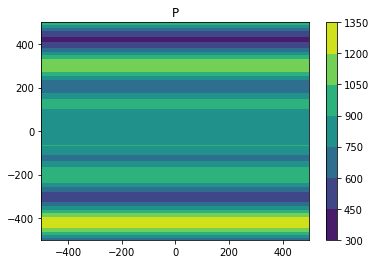

In [251]:
from matplotlib.animation import FuncAnimation
from functools import partial
plt.rcParams["animation.html"] = "html5"
plt.rcParams['animation.ffmpeg_path'] = 'C:\\ffmpeg\\bin\\ffmpeg.exe'

obj_fun = gb.Schwefel26()


w1 = np.linspace(start=obj_fun.bounds[0][0], 
                 stop=obj_fun.bounds[0][1],
                 num=500)

w2 = np.linspace(start=obj_fun.bounds[1][0], 
                 stop=obj_fun.bounds[1][1], 
                 num=500)

#x = np.random.rand(n)*l
p = np.array([ np.array([func(np.array(w1_, w2_)) for w2_ in w2]) for w1_ in w1]) 

f, ax1 = plt.subplots(1, 1, sharey=True)

c1 = ax1.contourf(w1, w2, p, cmap="viridis")
plt.colorbar(c1, ax = ax1)
ax1.set_title('P')
'''
res, X_1, T= anneal(func, x_i, schedule='fast',
                        full_output=True, 
                        maxiter=1000, 
                        T0 = func(x_i),
                        lower=np.array (obj_fun.bounds[0]),
                        upper=np.array (obj_fun.bounds[1]), 
                        dwell=250, disp=True)

traj1, = ax1.plot([], [], 'r', animated=True, label='GD')

X_2 = gradient_descent(f, df, np.array(obj_fun.generator()))

X_1 = np.array(X_1)
X_2 = np.array(X_2)

traj2, = ax1.plot([], [], 'w', animated=True, label='SGD')

ax1.legend()

def init():
    return traj1, traj2

def update(frame):
    traj1.set_data(X_1[:frame, 0], X_1[:frame, 1])
    traj2.set_data(X_2[:frame, 0], X_2[:frame, 1])
    return traj1, traj2

f.set_size_inches(12, 5)
#f.suptitle(f'2 routers, {nsteps} steps')
          
FuncAnimation(f, update, frames=range(max(len(X_1),len(X_2))), interval=120,
                    init_func=init, blit=True)'''

In [225]:
max(1,2)

2

In [117]:
T

[0.0, 0.0]